## map2loop: From geology layers to outputs to various 3D modelling programs- Hamersley example (Geomodeller)

This notebook reads in three layers from  local or remote sources:  geology polygons, orientation data and fault polylines; and calculates the topological relationships between the different features. Requires compiled cpp code from Vitaliy Ogarko

This all gets fed into successive tolopogical and geometric transfroms that end up feeding into geomodeller to make a 3D model 
<img src='../graphics/map_sm.png'>

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import sys
import stat
import functools 
import operator  
import matplotlib
import networkx as nx
import rasterio
from shapely.geometry import Polygon
from map2loop import m2l_utils
from map2loop import m2l_topology
from map2loop import m2l_geometry
from map2loop import m2l_interpolation
from map2loop import m2l_export
%matplotlib inline

#newwd="C:\\Users\\00073294\Dropbox\\loop_minex\\map2model\\"
#os.chdir(newwd)
print("Current Working Directory " )

gdal_data = os.environ['GDAL_DATA']
print("***",gdal_data)
print('is dir: ' + str(os.path.isdir(gdal_data)))
gcs_csv = os.path.join(gdal_data, 'gcs.csv')
print('is file: ' + str(os.path.isfile(gcs_csv)))
st = os.stat(gcs_csv)
print('is readable: ' + str(bool(st.st_mode & stat.S_IRGRP)))
os.environ['PROJ_LIB']=r"C:\\Users\\00073294\\AppData\\Local\\Continuum\\anaconda3\\Lib\\site-packages\\pyproj\\proj_dir\\share\\proj"
print(os.getenv('PROJ_LIB'))
print(os.getcwd())

Current Working Directory 
*** C:\Program Files\PostgreSQL\11\gdal-data
is dir: True
is file: True
is readable: True
C:\\Users\\00073294\\AppData\\Local\\Continuum\\anaconda3\\Lib\\site-packages\\pyproj\\proj_dir\\share\\proj
C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop\notebooks


## Create bounding box based on inputs

In [2]:
test_data_name='test_data3'

test_data_path='../'+test_data_name+'/'

os.chdir(test_data_path)
%run -i "m2l_config.py"
#%run -i "m2l_config_remote.py"
print(os.getcwd())

bbox2=str(minx)+","+str(miny)+","+str(maxx)+","+str(maxy)
lat_point_list = [miny, miny, maxy, maxy, maxy]
lon_point_list = [minx, maxx, maxx, minx, minx]
bbox_geom = Polygon(zip(lon_point_list, lat_point_list))
polygon = gpd.GeoDataFrame(index=[0], crs=dst_crs, geometry=[bbox_geom]) 
bbox=(minx,miny,maxx,maxy)


Default parameters loaded from ../test_data3/m2l_config.py:
#ROI

step_out=0.1   #padding arounf dtm to ensure reprojected dtm covers target area (in degrees)
inset=0      #unused??

minx=500057  #region of interest coordinates in metre-based system (or non-degree system)
maxx=603028
miny=7455348
maxy=7567953
model_top=1200
model_base=-8200

#PATHS

local_paths=True       #flag to use local or WFS source for data inputs (True = local)

test_data_path='../test_data3/'
m2m_cpp_path='../m2m_cpp/'

geology_file='hams2_geol.shp'   #input geology file (if local)
fault_file='GEOS_GEOLOGY_LINEARSTRUCTURE_500K_GSD.shp' #input fault file (if local)
structure_file='hams2_structure.shp' #input bedding orientation file (if local)
mindep_file='mindeps_2018.shp' #input mineral deposit file (if local)


#CRS

src_crs = {'init': 'EPSG:4326'}  # coordinate reference system for imported dtms (geodetic lat/long WGS84)
dst_crs = {'init': 'EPSG:28350'} # coordinate system for data

#codes and labels these r

In [3]:

fold_decimate=2         

contact_decimate=5

use_interpolations=True       #use interpolated dips/contacts as additional constraints

use_fat=True                   #use fold axial trace orientation hints

pluton_form='domes'

fault_dip=-999

min_fault_length=5000

compute_etc=False

## Preprocess data to ensure it meets modelling requirements

In [4]:
if(local_paths): ###############FUDGE#############
    use_gcode=('Hamersley_Group','Fortescue_Group','Turee_Creek_Group','A_mgn_PRK',  'A_mgn_PMI' ) ################# MOVE UP   #########################
    #use_gcode=('Hamersley_Group','Fortescue_Group','Wyloo_Group','Shingle_Creek_Group','Turee_Creek_Group','A_mgn_PRK',  'A_mgn_PMI' ) ################# MOVE UP   #########################
else:
    use_gcode=('Hamersley_Group','Fortescue_Group','Wyloo_Group','Shingle_Creek_Group','Turee_Creek_Group','A_mgn_PMI',  'A_mgn_PRK' ) ################# MOVE UP   #########################


print('only processing',use_gcode)

#inputs=('invented_orientations','interpolated_orientations','intrusive_orientations','fat_orientations','near_fault_orientations')
#inputs=('invented_orientations','interpolated_orientations','intrusive_orientations','fat_orientations','near_fault_orientations')
inputs=('invented_orientations','intrusive_orientations','fat_orientations','near_fault_orientations')

m2l_geometry.tidy_data(output_path,tmp_path,use_gcode,use_interpolations,use_fat,pluton_form,inputs)

only processing ('Hamersley_Group', 'Fortescue_Group', 'Turee_Creek_Group', 'A_mgn_PRK', 'A_mgn_PMI')


## Analyse fault-fault topology

C:\Users\00073294\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\00073294\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


cycles [['Fault_313', 'Fault_2837', 'Fault_16825', 'Fault_7966']]


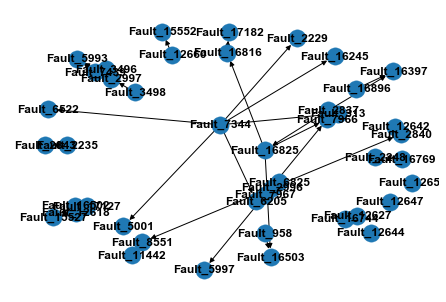

In [5]:
m2l_topology.parse_fault_relationships(graph_path,tmp_path,output_path)

# loop2gemodeller test 



In [6]:
save_faults=True
compute_etc=False

m2l_export.loop2geomodeller(test_data_path,tmp_path,output_path,'./dtm/dtm_rp.tif',bbox,save_faults,compute_etc)

In [7]:
os.chdir(test_data_path)
%system geomodellerbatch.exe -batch m2l.taskfile


['WARNING: An illegal reflective access operation has occurred',
 'WARNING: Illegal reflective access by com.dfa.util.Lib (file:/C:/GeoModeller/GeoModeller4.0.8_x64_88b64e610d9/bin/plugins/au.com.dfa.intrepid.lib_6.0.0.201911202221.jar) to field java.lang.ClassLoader.loadedLibraryNames',
 'WARNING: Please consider reporting this to the maintainers of com.dfa.util.Lib',
 'WARNING: Use --illegal-access=warn to enable warnings of further illegal reflective access operations',
 'WARNING: All illegal access operations will be denied in a future release',
 'COMPOSE EXTRA LENGTH FOR A_mgn_PRK 0',
 'COMPOSE EXTRA LENGTH FOR A_mgn_PMI 0',
 'COMPOSE EXTRA LENGTH FOR Fortescue_Group 0',
 'COMPOSE EXTRA LENGTH FOR Hamersley_Group 0',
 'COMPOSE EXTRA LENGTH FOR Turee_Creek_Group 0']

In [8]:
#%system geomodellerbatch.exe -batch m2l_compute.taskfile


In [9]:
import winsound
duration = 500  # milliseconds
freq = 1100  # Hz
winsound.Beep(freq, duration)
winsound.Beep(freq, duration)
duration=999
winsound.Beep(freq, duration)
